In [2]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib as plt
from matplotlib import cm
import plotly.express as px
import collections

To use custom maps, you need to register on mapbox and get a token (100,000 free uses). The personal token must be written to mapbox_tkn.txt and imported (you can directly write it into the code, but then everyone will see it and be able to use it).

In [3]:
with open('mapbox_tkn.txt', 'r') as f:
    mapbox_key = f.read().strip()

Dataset from: http://oxrep.classics.ox.ac.uk/databases/cities/

In [4]:
xls = pd.ExcelFile('Hanson2016_CitiesDatabase_OxREP.xlsx')
roman_cities = pd.read_excel(xls, 'Cities')
roman_monuments = pd.read_excel(xls, 'Monuments')
roman_cities

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,37.750074,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,38.147951,DGRG; Hansen and Nielsen 2004.
...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,22.680752,42.282517,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,24.750913,42.146652,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,25.529249,40.500693,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,23.342891,42.722826,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...


The rank of a city indicates its size and influence. They are distributed a little strange, this needs to be corrected.

In [5]:
roman_cities['Barrington Atlas Rank'].unique()

array(['4 or 5', 3, 2, 1, '-'], dtype=object)

That's better

In [6]:
roman_cities = roman_cities.replace({'-': 5, '4 or 5': 4})
roman_cities['Barrington Atlas Rank'].unique()

array([4, 3, 2, 1, 5], dtype=int64)

Broken key Hanson2016_

In [7]:
roman_monuments.sort_values('Primary Key')

,Primary Key,Structure
9339,Hanson2016_,Agora?
4,Hanson2016_1,Walls
3,Hanson2016_1,Theatre
0,Hanson2016_1,Acropolis
1,Hanson2016_1,Agora
...,...,...
6721,Hanson2016_998,Forum
6722,Hanson2016_998,Mithraeum
6723,Hanson2016_998,Walls
6725,Hanson2016_999,Walls


Looks like just a mistake

In [8]:
roman_monuments.iloc[9337:9342]

,Primary Key,Structure
9337,Hanson2016_1370,Urban grid?
9338,Hanson2016_1371,Agora?
9339,Hanson2016_,Agora?
9340,Hanson2016_1371,Urban grid
9341,Hanson2016_1371,Walls


That's better

In [9]:
roman_monuments = roman_monuments[roman_monuments['Primary Key'] != 'Hanson2016_']
roman_monuments

,Primary Key,Structure
0,Hanson2016_1,Acropolis
1,Hanson2016_1,Agora
2,Hanson2016_1,Temple of Apollo
3,Hanson2016_1,Theatre
4,Hanson2016_1,Walls
...,...,...
9467,Hanson2016_1388,Temple of Dionysus
9468,Hanson2016_1388,Urban grid
9469,Hanson2016_1388,Walls
9470,Hanson2016_167,Theatre


Adding monuments from one city to one cell

In [10]:
roman_monuments_g = roman_monuments.groupby('Primary Key')['Structure'].apply(lambda x: ', '.join(x)).reset_index()
roman_monuments_g

,Primary Key,Structure
0,Hanson2016_1,"Acropolis, Agora, Temple of Apollo, Theatre, W..."
1,Hanson2016_10,"Acropolis, Gymnasium, Sanctuary of Poseidon, W..."
2,Hanson2016_100,"Acropolis, Fountain, Gymnasium, Gymnasium, Hip..."
3,Hanson2016_1000,Temple
4,Hanson2016_1001,"Acropolis, Aqueduct, Baths, Unidentified publi..."
...,...,...
1202,Hanson2016_993,"Amphitheatre, Basilica, Baths?, Forum, Temple ..."
1203,Hanson2016_995,"Aqueduct, Baths, Forum, Unidentified public bu..."
1204,Hanson2016_996,"Temple, Walls"
1205,Hanson2016_998,"Amphitheatre, Baths, Forum, Mithraeum, Walls"


Looks good

In [11]:
roman_cities_monuments = pd.merge(roman_cities, roman_monuments_g, on=['Primary Key', 'Primary Key'], how='left')
roman_cities_monuments

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography,Structure
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,"Acropolis, Agora, Temple of Apollo, Theatre, W..."
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.,"Sanctuary of Apollo Argyieus, Sanctuary of Her..."
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,"Acropolis, Agora, Fountain, Temple of Apollo P..."
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,37.750074,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,"Shrine of Aeacus, Stadium, Temple of Aphrodite..."
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,38.147951,DGRG; Hansen and Nielsen 2004.,"Acropolis, Agora, Gymnasium, Temple of Aphrodi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,22.680752,42.282517,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.,"Acropolis, Baths, Forum, Gymnasium, Temple of ..."
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,24.750913,42.146652,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...,"Acropolis, Agora, Aqueduct, Baths, Hippodrome,..."
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,25.529249,40.500693,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,"Acropolis, Sanctuary of the Great Gods, Stoa, ..."
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,23.342891,42.722826,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...,"Amphitheatre, Basilica, Baths, Bouleuterion, F..."


Since there can be identical monuments in the same city, they can be counted (improves visual perception). Plotly may not show the labels of some cities (Rome for example) because there are a large number of monuments on their territory. We define such cities and display "Look in the reference book" instead of the list of monuments

In [12]:
def monuments_counter(structure:str):
    stroka = ''
    words = structure.split(', ')
    word_counts = collections.Counter(words)
    for word, count in sorted(word_counts.items()):
        stroka += '%sx %s,<br>' % (count, word)
    if len(stroka.split(',<br>')) > 45:
        return 'Look in the reference book (a lot of monuments)<br>'
    else:
        return stroka[:-5] + '.<br>'

Looks good

In [13]:
roman_cities_monuments['Structure_с'] = roman_cities_monuments['Structure'].fillna('Not found').apply(monuments_counter)
roman_cities_monuments

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography,Structure,Structure_с
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,"Acropolis, Agora, Temple of Apollo, Theatre, W...","1x Acropolis,<br>1x Agora,<br>1x Temple of Apo..."
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.,"Sanctuary of Apollo Argyieus, Sanctuary of Her...","1x Sanctuary of Apollo Argyieus,<br>1x Sanctua..."
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,"Acropolis, Agora, Fountain, Temple of Apollo P...","1x Acropolis,<br>1x Agora,<br>1x Fountain,<br>..."
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,37.750074,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,"Shrine of Aeacus, Stadium, Temple of Aphrodite...","1x Shrine of Aeacus,<br>1x Stadium,<br>1x Temp..."
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,38.147951,DGRG; Hansen and Nielsen 2004.,"Acropolis, Agora, Gymnasium, Temple of Aphrodi...","1x Acropolis,<br>1x Agora,<br>1x Gymnasium,<br..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,22.680752,42.282517,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.,"Acropolis, Baths, Forum, Gymnasium, Temple of ...","1x Acropolis,<br>1x Baths,<br>1x Forum,<br>1x ..."
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,24.750913,42.146652,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...,"Acropolis, Agora, Aqueduct, Baths, Hippodrome,...","1x Acropolis,<br>1x Agora,<br>1x Aqueduct,<br>..."
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,25.529249,40.500693,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,"Acropolis, Sanctuary of the Great Gods, Stoa, ...","1x Acropolis,<br>1x Sanctuary of the Great God..."
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,23.342891,42.722826,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...,"Amphitheatre, Basilica, Baths, Bouleuterion, F...","1x Amphitheatre,<br>1x Basilica,<br>1x Baths,<..."


We select the largest cities for beauty

In [14]:
roman_cities_rank_1 = roman_cities_monuments[roman_cities_monuments['Barrington Atlas Rank'] == 1]
roman_cities_rank_other = roman_cities_monuments[roman_cities_monuments['Barrington Atlas Rank'] != 1] 

Looks good

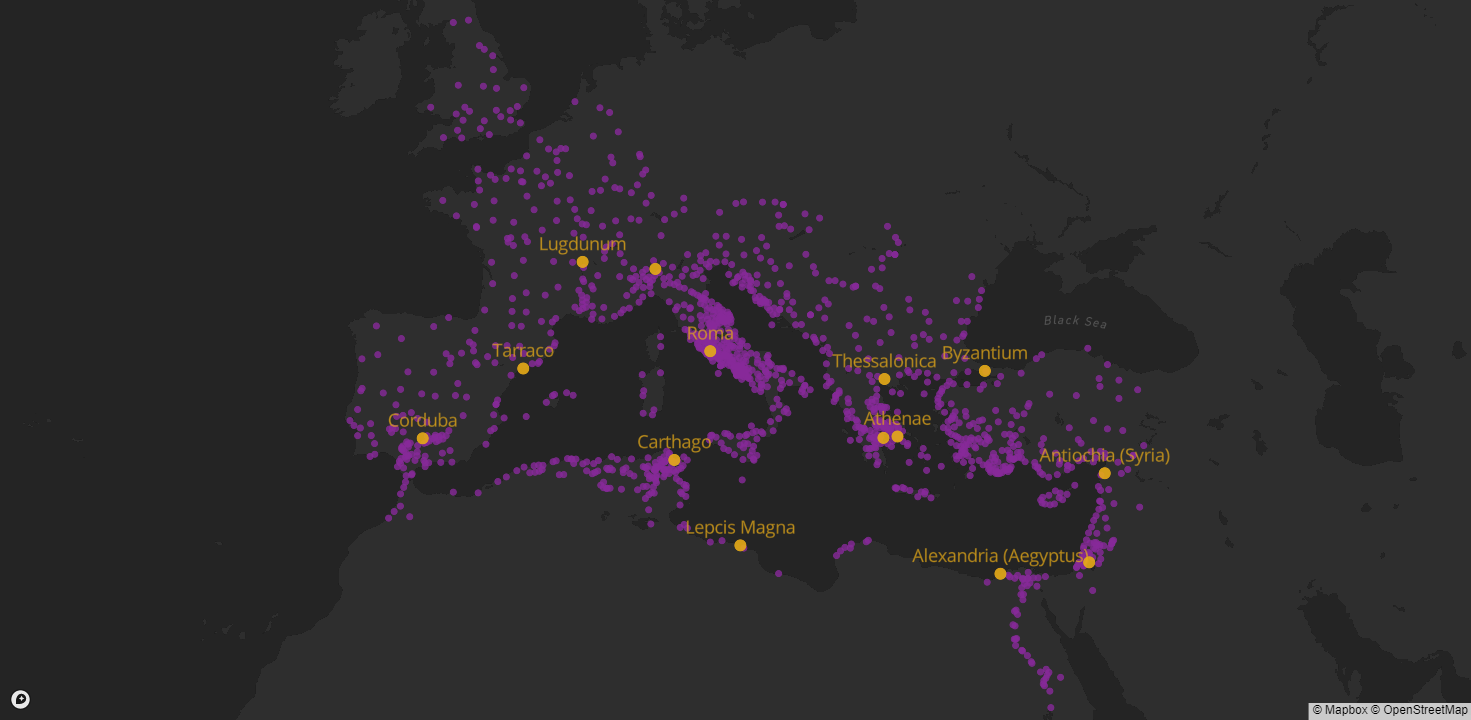

In [16]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat=roman_cities_rank_other['Latitude (Y)'], lon=roman_cities_rank_other['Longitude (X)'], 
                               mode='markers',
                               marker=go.scattermapbox.Marker(size=8,color='#872999',opacity=0.8),
                               text=roman_cities_rank_other['Ancient Toponym'],
                               hovertext=roman_cities_rank_other['Structure_с'],
                               hovertemplate ="<b>%{text} </b><br><br>" + "Monuments:<br>%{hovertext}<br>" + "Longitude: %{lon}<br>" + "Latitude: %{lat}<br>"))

fig.add_trace(go.Scattermapbox(lat=roman_cities_rank_1['Latitude (Y)'], lon=roman_cities_rank_1['Longitude (X)'], 
                               mode='markers+text',
                               marker=go.scattermapbox.Marker(size=13,color='#E6AA17',opacity=0.9),
                               text=roman_cities_rank_1['Ancient Toponym'],
                               textfont=dict(family="open sans",size=18,color="#E6AA17"), 
                               textposition='top center',
                               hovertext=roman_cities_rank_1['Structure_с'],
                               hovertemplate ="<b>%{text} </b><br><br>" + "Monuments:<br>%{hovertext}<br>" + "Longitude: %{lon}<br>" + "Latitude: %{lat}<br>"))

    
fig.update_layout(mapbox_style="mapbox://styles/vonorso/ckyrdovj14inm15mw7pa289y7",)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, width=1280, height=720, mapbox_center = {"lat": 41.5, "lon": 14.0}, mapbox_zoom=3.55, mapbox_accesstoken=mapbox_key, showlegend=False)
fig.show()